In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import migKeyPoint.utils.YAMLtools as yt

### Aside: let's begin by setting up our environment by reading master_configuration.yaml

Conf will be used later on when we get into generating images and labels for training YOLO. I've set up this configuration environment so the user doesn't have to find specific notebook cells to edit. Instead, you can just edit master_configuration.yaml. You can feel free to expand master_configuration.yaml as needed.

In [6]:
conf = yt.load_configuration('../master_configuration.yaml')['yoloConf']

In [7]:
'''Conf is a dictionary'''
conf

{'project_dir': '/home/jeff/workspace/migKeyPoint/migKeyPoint/tutorial',
 'pretrained_model_path': '../pretrained/linear/best.pt',
 'noise': False,
 'log_scale': False,
 'cameraX': 2048,
 'cameraY': 1152,
 'outputX': 512,
 'outputY': 288,
 'maxNumKeyPoints': 9,
 'GPU': True,
 'project': '/home/jeff/workspace/migKeyPoint/migKeyPoint/tutorial/models/linear',
 'suffix': '_linear'}

### Okay, now the processing begins. Let's start by loading simulation

In [8]:
'''Load simulated ERs'''
ERs = pd.read_feather('../simulation/ERs_cont_spectrum_correctE.feather')

In [9]:
ERs.head()

,x,y,q,xvtx,yvtx,E,theta,phi,phid,thetad
0,"[927, 914, 915, 921, 922, 924, 925, 928, 906, ...","[373, 374, 374, 374, 374, 374, 374, 374, 375, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, ...",919.570,414.087111,3.4,0.214,3.277,187.758269,12.261297
1,"[646, 631, 644, 645, 646, 628, 630, 632, 633, ...","[70, 71, 72, 72, 72, 73, 73, 73, 73, 73, 73, 7...","[1, 2, 1, 3, 1, 1, 1, 2, 1, 2, 1, 3, 2, 1, 2, ...",646.162,145.287111,3.4,1.526,2.781,159.339563,87.433360
2,"[1005, 1005, 1006, 1007, 1010, 1004, 1005, 100...","[266, 267, 267, 267, 267, 268, 268, 268, 268, ...","[1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, ...",997.138,326.279111,3.4,0.947,1.996,114.362376,54.259103
3,"[612, 612, 613, 614, 616, 617, 610, 612, 613, ...","[506, 507, 507, 507, 507, 507, 508, 508, 508, ...","[1, 4, 4, 3, 1, 1, 1, 3, 5, 5, 3, 3, 3, 2, 6, ...",622.610,556.167111,3.4,2.051,5.334,305.615688,117.513644
4,"[761, 763, 762, 764, 765, 762, 763, 764, 766, ...","[391, 391, 392, 392, 392, 393, 393, 393, 393, ...","[1, 1, 1, 2, 2, 2, 4, 2, 2, 1, 1, 2, 1, 6, 2, ...",763.666,434.823111,3.4,0.881,2.886,165.355620,50.477582


### Now we approximate the head as the point with highest intensity and use the truth simulated vertex as the tail. These are our track endpoints and we will use these as boundaries to define our keypoint training labels

In [10]:
def find_head(df,i):
    tmp = df.iloc[i]
    indices = pd.Series(tmp['q']).nlargest(3).index.to_numpy()
    return np.median(tmp['x'][indices]),np.median(tmp['y'][indices])

In [11]:
xs = []
ys = []
for i in tqdm(range(0,len(ERs))):
    x,y = find_head(ERs,i)
    xs.append(x)
    ys.append(y)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10500/10500 [00:21<00:00, 484.62it/s]


In [12]:
ERs['xhead'] = xs
ERs['yhead'] = ys

In [13]:
ERs.head()

,x,y,q,xvtx,yvtx,E,theta,phi,phid,thetad,xhead,yhead
0,"[927, 914, 915, 921, 922, 924, 925, 928, 906, ...","[373, 374, 374, 374, 374, 374, 374, 374, 375, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, ...",919.570,414.087111,3.4,0.214,3.277,187.758269,12.261297,925.0,411.0
1,"[646, 631, 644, 645, 646, 628, 630, 632, 633, ...","[70, 71, 72, 72, 72, 73, 73, 73, 73, 73, 73, 7...","[1, 2, 1, 3, 1, 1, 1, 2, 1, 2, 1, 3, 2, 1, 2, ...",646.162,145.287111,3.4,1.526,2.781,159.339563,87.433360,649.0,126.0
2,"[1005, 1005, 1006, 1007, 1010, 1004, 1005, 100...","[266, 267, 267, 267, 267, 268, 268, 268, 268, ...","[1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, ...",997.138,326.279111,3.4,0.947,1.996,114.362376,54.259103,993.0,330.0
3,"[612, 612, 613, 614, 616, 617, 610, 612, 613, ...","[506, 507, 507, 507, 507, 507, 508, 508, 508, ...","[1, 4, 4, 3, 1, 1, 1, 3, 5, 5, 3, 3, 3, 2, 6, ...",622.610,556.167111,3.4,2.051,5.334,305.615688,117.513644,635.0,548.0
4,"[761, 763, 762, 764, 765, 762, 763, 764, 766, ...","[391, 391, 392, 392, 392, 393, 393, 393, 393, ...","[1, 1, 1, 2, 2, 2, 4, 2, 2, 1, 1, 2, 1, 6, 2, ...",763.666,434.823111,3.4,0.881,2.886,165.355620,50.477582,764.0,430.0


### To keep "nice" ER tracks, we can cut on the distance between the track vertex and track head which I'm calling 'htlength' which is short for head/tail length. 
This isn't something we generally want to do, but I'm doing this so we can automatically generate decent-looking keypoint sets easily. In general we want something that works even for ERs following the most complicated trajectories, but this is just a demonstration

In [14]:
ERs['htlength'] = np.sqrt((ERs['xvtx']-ERs['xhead'])**2+(ERs['yvtx']-ERs['yhead'])**2)

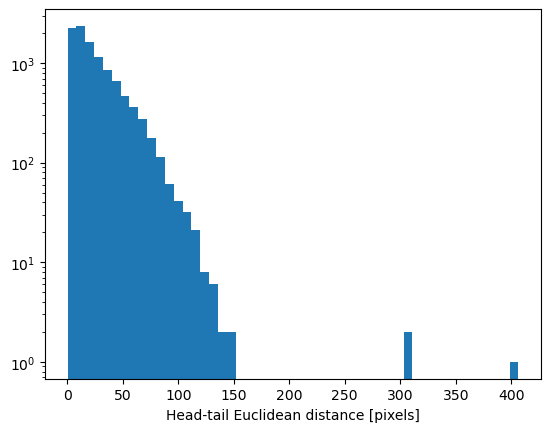

'Most tracks have short head/tail lengths. We"re going to consider longer lengths, \nas trajectories are less ambiguous for these'

In [15]:
'''Whenever you define a new variable that you can make cuts on, it"s generally good practice
to look at the distribution of the variable'''

plt.hist(ERs['htlength'],bins=51)
plt.xlabel('Head-tail Euclidean distance [pixels]')
plt.yscale('log')
plt.show()

'''Most tracks have short head/tail lengths. We"re going to consider longer lengths, 
as trajectories are less ambiguous for these'''

### Centering tracks to make rotations easier. This step isn't strictly necessary but I'm doing it for this example

In [16]:
conf

{'project_dir': '/home/jeff/workspace/migKeyPoint/migKeyPoint/tutorial',
 'pretrained_model_path': '../pretrained/linear/best.pt',
 'noise': False,
 'log_scale': False,
 'cameraX': 2048,
 'cameraY': 1152,
 'outputX': 512,
 'outputY': 288,
 'maxNumKeyPoints': 9,
 'GPU': True,
 'project': '/home/jeff/workspace/migKeyPoint/migKeyPoint/tutorial/models/linear',
 'suffix': '_linear'}

In [17]:
'''Center all tracks. First shift the vertex and head columns, then do the entire track'''
ERs['xvtx'] = ERs['xvtx']-ERs['x'].apply(lambda x: x.min())+conf['cameraX']//2
ERs['yvtx'] = ERs['yvtx']-ERs['y'].apply(lambda x: x.min())+conf['cameraY']//2
ERs['xhead'] = ERs['xhead']-ERs['x'].apply(lambda x: x.min())+conf['cameraX']//2
ERs['yhead'] = ERs['yhead']-ERs['y'].apply(lambda x: x.min())+conf['cameraY']//2

ERs['x'] = ERs['x'].apply(lambda x: x-x.min()+conf['cameraX']//2)
ERs['y'] = ERs['y'].apply(lambda x: x-x.min()+conf['cameraY']//2)

# This method is what we're using to generate simulated key points.
**These keypoints are what we will use to label our data to train YOLO. Any supervised learning task requires to be trained on labeled data. For this example, I thought it would be better to automate the key point generation, rather than making us label a ton of data by hand.**

You might be wondering, "wait, if we can automatically generate key points, then what's the point of using YOLO?" Well, the point of training YOLO is to come up with a general way of identifying key points. The method we're using here works because (a) we don't have noise to begin with, and most importantly, (b) we know the vertex (tail) of simulated ER tracks. Knowledge of the vertex is needed for the method below to work and in general, the tail of ERs is difficult to find in real data using first principles approaches. So, we'll use this method to generate sets of key points to train YOLO on, then we'll train YOLO, and then we'll test it's predictions on data it wasn't trained on and see how it compares to this method.

In [18]:
import numpy as np
from scipy.sparse import coo_matrix

class generate_keypoints:
    '''Class takes a sparse image, rotates it so the head and tail are vertically aligned.
    Then it partitions the interval between the head and tail into n_outputs + 2 equally spaced subdivisions
    and records the (x',y') coordinate of either (a) the max intensity [if the mode parameter is set to 'max']
    or (b), the median (x',y') over the 9 most intense pixels in each partition. The code then rotates the set of
    (x',y')s back to the original image orientation, which are our keypoints!'''
    
    def __init__(self,df,i,n_outputs=1,dim=(2048,1152),mode='max'):
        if mode.lower() != 'max' and mode.lower() != 'median':
            raise ValueError("mode must be 'max' or 'median'")
        self.mode = mode.lower()
        evt = df.iloc[i]
        self.n_outputs = n_outputs
        self.center_x = dim[1] // 2
        self.center_y = dim[0] // 2
        self.col = evt['x'].astype('int')
        self.row = evt['y'].astype('int')
        self.data = evt['q']
        self.head = np.array([evt['xhead'],evt['yhead']])
        self.tail = np.array([evt['xvtx'],evt['yvtx']])
        self.rotation_angle = self.get_rotation_angle()
        
        '''Rotation matrices, backward rotation is used to translate track segments back to original'''
        self.forward_rotation = self.generate_rotation_matrix(self.rotation_angle)
        self.reverse_rotation = np.linalg.inv(self.forward_rotation)
        
        '''Rotate head and tail to rotated space'''
        self.rothead = self.rotate_coord(self.head[::-1],self.forward_rotation)
        self.rottail = self.rotate_coord(self.tail[::-1],self.forward_rotation)
        
        #print(self.rotate_coord(self.rothead,self.reverse_rotation))
        '''Generate rotated sparse image'''
        self.rot_im = self.rotate_sparse_image()
        
        '''Get segmented coordinates in rotated space'''
        self.rot_segments = np.array(self.get_segment_coordinates()).T
        self.segments = []
        self.segments.append((evt['xvtx'],evt['yvtx']))
        for coord in self.rot_segments:
            self.segments.append(self.rotate_coord(coord,self.reverse_rotation)[::-1])
        self.segments.append((evt['xhead'],evt['yhead']))
    def get_rotation_angle(self):
        vec = np.array([self.head[0]-self.tail[0],self.head[1]-self.tail[1]])
        theta = np.arctan2(vec[1],vec[0])
        return theta

    def generate_rotation_matrix(self,theta):
        cos_angle = np.cos(theta)
        sin_angle = np.sin(theta)
        
        rotation_matrix = np.array([
            [cos_angle, sin_angle],
            [-sin_angle, cos_angle]
        ])
            
        return rotation_matrix

    def rotate_sparse_image(self):
        sparse_matrix = coo_matrix((self.data, (self.row, self.col)), shape=(1152,2048))
        # Center of the image

        # Translate coordinates to origin
        translated_x = self.col - self.center_x
        translated_y = self.row - self.center_y

        # Apply rotation
        new_coords = np.dot(self.forward_rotation, np.array([translated_x, translated_y]))

        new_x = np.round(new_coords[0] + self.center_x).astype('int')
        new_y = np.round(new_coords[1] + self.center_y).astype('int')

        # Filter out-of-bounds coordinates
        valid_mask = (new_x >= 0) & (new_x < sparse_matrix.shape[1]) & (new_y >= 0) & (new_y < sparse_matrix.shape[0])
        new_x = new_x[valid_mask]
        new_y = new_y[valid_mask]
        new_data = self.data[valid_mask]

        # Create the rotated sparse matrix
        rotated_sparse_matrix = coo_matrix((new_data, (new_y, new_x)), shape=sparse_matrix.shape)
        return rotated_sparse_matrix.toarray().T
    
    def rotate_coord(self,coord,rot):
        original_coordinate = coord

        # Translate coordinate to origin
        translated_x = original_coordinate[1] - self.center_x
        translated_y = original_coordinate[0] - self.center_y

        # Apply rotation
        new_coord = np.dot(rot, np.array([translated_x, translated_y]))

        # Translate back to the original coordinate system
        new_coordinate = (new_coord[1] + self.center_y, new_coord[0] + self.center_x)
        return new_coordinate
    
    def get_segment_coordinates(self):
        n_partitions = self.n_outputs+2
        y_segments = np.linspace(self.rottail[1],self.rothead[1],n_partitions)[1:-1]
        x_segments = []
        for seg in y_segments:
            if self.mode == 'max':
                x_coord = np.median(np.where(self.rot_im[int(np.round(seg)),:] == self.rot_im[int(np.round(seg)),:].max())[0])
            elif self.mode == 'median':
                indices = pd.Series(self.rot_im[int(np.round(seg)),:]).nlargest(9).index.to_numpy()
                x_coord = np.median(indices)
            x_segments.append(x_coord)
        x_segments = np.array(x_segments)
        if np.mean(x_segments) != 575.5 and np.mean(x_segments) != 4:
            return x_segments,y_segments
        else:
            raise ValueError("Bad rotation")

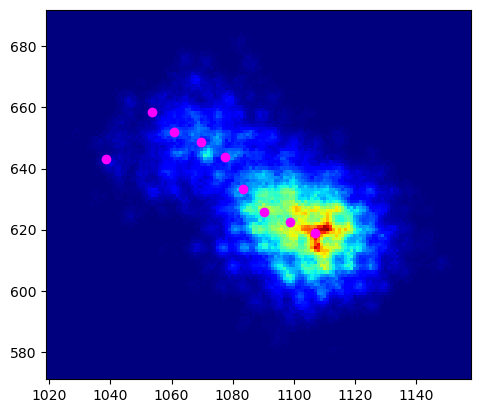

In [19]:
'''Let"s test the output of this method. We"ll run it on one event and then plot the output'''

#We're generating keypoints for track 11 of the set of ERs with htlength > 11
#Remember conf['maxNumKeyPoints'] is the total number of keypoints in our sample which includes the head and tail
#We therefore generate conf['maxNumKeyPoints']-2 points
#Feel free to play around with the n_outputs parameter here but make sure you set the desired number of
#key points in master_configuration.yaml when performing a study
a = generate_keypoints(ERs.query('htlength > 50'),i = 11,n_outputs = conf['maxNumKeyPoints']-2,mode = 'median') #can change 'median' to 'max' to test what happens

'''Our simulation has track coordinates stored as sparse arrays, meaning it only saves the coordinates
of pixels with non-zero content. To form images our of sparse arrays you can just histogram the sparse
array content, setting the bins and range to be appropriate for the camera'''
im = np.histogram2d(a.col,a.row,weights=a.data,bins=(2048,1152),range=((0,2048),(0,1152)))[0].T

#plot image
plt.imshow(im,cmap='jet')
#Zoom into track
plt.xlim(a.col.min()-5,a.col.max()+5)
plt.ylim(a.row.min()-5,a.row.max()+5)

#Plot segments we generated
for seg in a.segments: #a.segments are the output of generate_keypoints
    plt.plot(seg[0],seg[1],'o',color='magenta')

plt.xlim()
plt.show()

### Now let's process all events with 50 < htlength < 200. This cut gives us the longer ER tracks but omits the exceptionally long outliers we saw in the previous histogram

In [20]:
'''There"s an apparent bug in the keypoint generation code where certain kinds of rotations mess things up.
I"ve figured out how to flag these, but haven"t figured out how to fix this. Nevertheless, since this is
meant to be a minimal working example, we won"t sweat this. Because of this bug, there will be a preferred 
direction in the trajectories that do generate. Generally speaking training on a preferred direction will 
bias a machine learning model which we don"t want.'''

ERs = ERs.query('200 > htlength > 50')
ERs.index = [i for i in range(0,len(ERs))]

good_indices = []
coords = {} #dictionary filled with keypoint tuples
for i in range(0,len(a.segments)):
    coords[i] = []

for i in tqdm(range(0,len(ERs))):
    try:
        a = generate_keypoints(ERs,i,n_outputs=conf['maxNumKeyPoints']-2,mode='median')
        good_indices.append(i)
        for j in range(0,len(a.segments)):
            coords[j].append(a.segments[j])
    except:
        #print("Bad rotation")
        continue

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1437/1437 [00:18<00:00, 76.77it/s]


In [21]:
'''Reduce our dataframe to only include entries where the trajectory generated'''
ERs = ERs.loc[ERs.index.isin(good_indices)] #only keep the events where the loop above didnt fail
ERs.index = [i for i in range(0,len(ERs))]

### Now we need to format our data consistent with what YOLOv8 requires. We use the format with dim = 2 from https://docs.ultralytics.com/datasets/pose/#supported-dataset-formats shown below

class-index, x, y, width, height, px1, py1, px2, py2,...,pxn, pyn

Where

**class_index**: 0 (choice is up to us but this is what I use for ERs)\
**xBB**: x coordinate of the center of the bounding box (BB) surrounding the track\
**yBB**: y coordinate of the center of the bounding box surrounding the track\
**width**: width of the bounding box\
**height**: height of the bounding box\
**pxN**: x coordinate of the Nth key point. **Key points should be ordered so we'll get head/tail out of the box!** \
**pyN**: y coordinate of the Nth key point. **Key points should be ordered so we'll get head/tail out of the box!**

In [16]:
'''Whenever I"m processing data, I like to check the columns in my dataframe periodically'''
ERs.columns

Index(['x', 'y', 'q', 'xvtx', 'yvtx', 'E', 'theta', 'phi', 'phid', 'thetad',
       'xhead', 'yhead', 'htlength'],
      dtype='object')

In [22]:
'''Make class_index, x, y, width, and height columns'''

ERs['class_index'] = 0

'''Columns "x", "y", and "q" are array-based quantities. We can use pandas"s apply function and
lambda expressions to do array operations rowwise in a succinct way. Don"t worry if this notation
seems cryptic, once you get used to it, it"s very succinct and efficient for array operations
in pandas dataframes'''

ERs['xBB'] = ERs['x'].apply(lambda x: (x.max()+x.min())/2 / conf['cameraX']) #normalized as a fraction of width of image (2048 pixels)
ERs['yBB'] = ERs['y'].apply(lambda x: (x.max()+x.min())/2 / conf['cameraY']) #normalized as a fraction of height of image (1152 pixels)
ERs['width'] = ERs['x'].apply(lambda x: (x.max()-x.min()) / conf['cameraX'])
ERs['height'] = ERs['y'].apply(lambda x: (x.max()-x.min()) / conf['cameraY'])

In [18]:
'''Notice the configuration variables in these expressions. Let"s remind ourselves of the contents of
our configuration file'''
conf

{'project_dir': '/home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial',
 'pretrained_model_path': '',
 'noise': False,
 'log_scale': True,
 'cameraX': 2048,
 'cameraY': 1152,
 'outputX': 512,
 'outputY': 288,
 'maxNumKeyPoints': 9,
 'GPU': True,
 'project': '/home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial/models/log',
 'suffix': '_log'}

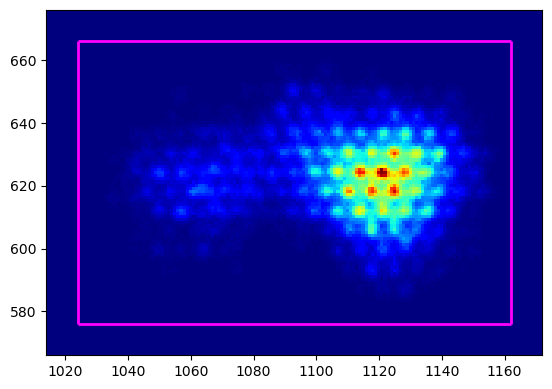

In [23]:
'''Lets plot a test image with a bounding box to test that we did it right'''
index = 15
tmp = ERs.iloc[index] #we'll plot frame 8
im = np.histogram2d(tmp['x'],tmp['y'],weights=tmp['q'],bins=(conf['cameraX'],conf['cameraY']),range=((0,conf['cameraX']),(0,conf['cameraY'])))[0].T
plt.imshow(im,cmap='jet')
plt.xlim(tmp['x'].min()-10,tmp['x'].max()+10)
plt.ylim(tmp['y'].min()-10,tmp['y'].max()+10)
xmin = (tmp['xBB']-tmp['width']/2)*conf['cameraX']
xmax = (tmp['xBB']+tmp['width']/2)*conf['cameraX']
ymin = (tmp['yBB']-tmp['height']/2)*conf['cameraY']
ymax = (tmp['yBB']+tmp['height']/2)*conf['cameraY']
plt.hlines(ymin,xmin,xmax,color='magenta',lw=2)
plt.hlines(ymax,xmin,xmax,color='magenta',lw=2)
plt.vlines(xmin,ymin,ymax,color='magenta',lw=2)
plt.vlines(xmax,ymin,ymax,color='magenta',lw=2)

### A reminder in case it isn't clear: the reason why we are able to generate bounding boxes like this is because we know the true boundaries of simulated tracks! This allows us to generate all labels automatically so we can train YOLO without hand labeling data

Now we will put our generated keypoints into the dataframe

In [24]:
'''Puts key point tuples into into columns p0 to pN'''
for key in coords.keys():
    ERs['p%s'%(key)] = coords[key]

In [25]:
'''Expands the tuples to p0x, p0y, p1x, p1y, etc.'''
# Initialize an empty dictionary to hold the new columns
new_columns = {}

# Iterate over each of the keypoint columns in the DataFrame
for col in ERs.columns[int(-1*conf['maxNumKeyPoints']):]: #apologies that this is
    # Extract x and y components from each column
    ERs[[f'{col}x', f'{col}y']] = pd.DataFrame(ERs[col].tolist(), index=ERs.index)
    # Drop the original column
    ERs.drop(columns=[col], inplace=True)

### Don't forget to normalize the keypoints too!

In [26]:
for i in range(0,conf['maxNumKeyPoints']):
    ERs['p%sx'%(i)] = ERs['p%sx'%(i)]/conf['cameraX']
    ERs['p%sy'%(i)] = ERs['p%sy'%(i)]/conf['cameraY']

In [27]:
'''Check the columns of our dataframe'''
ERs.columns

Index(['x', 'y', 'q', 'xvtx', 'yvtx', 'E', 'theta', 'phi', 'phid', 'thetad',
       'xhead', 'yhead', 'htlength', 'class_index', 'xBB', 'yBB', 'width',
       'height', 'p0x', 'p0y', 'p1x', 'p1y', 'p2x', 'p2y', 'p3x', 'p3y', 'p4x',
       'p4y', 'p5x', 'p5y', 'p6x', 'p6y', 'p7x', 'p7y', 'p8x', 'p8y'],
      dtype='object')

### Now let's generate image and label files for our training, validation, and test sets

### Step 0: Determine train / validation / test split. We're going to do this in the most rudimentary way. Scikit learn has a lot of information about good ways to do this that are worth looking up when you have the time. Here are a few examples:

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

https://machinelearningmastery.com/k-fold-cross-validation/

In [28]:
'''I"m manually splitting the data up into 70% train, 20% validation, 10% test. There are better and more
statistically robust ways of doing this, like using k-fold cross validation which I linked an article on
above. You also ALWAYS want to shuffle your data before splitting it up. A lot of scikit-learn"s convenience
functions automatically shuffle for you but we"ll do it manually here'''

dataset_size = len(ERs)
# Shuffle data
ERs = ERs.sample(frac=1,random_state=42) #Random state ensures we get identical shuffles every time for reproducability
ERs.index = [i for i in range(0,len(ERs))] #reset index after shuffling
ERs['index'] = ERs.index
data = {} #dictionary storing train, validation, and test datasets
data['train'] = ERs[:int(dataset_size*0.7)]
data['valid'] = ERs[int(dataset_size*0.7):int(dataset_size*0.9)]
data['test'] =  ERs[int(dataset_size*0.9):]
print('Train set size: %s\nval set size : %s\ntest set size: %s\nsum : %s\ndataset size: %s'%(len(data['train']),len(data['valid']),len(data['test']),len(data['train'])+len(data['valid'])+len(data['test']),dataset_size))

Train set size: 784
val set size : 224
test set size: 113
sum : 1121
dataset size: 1121


In [25]:
conf

{'project_dir': '/home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial',
 'pretrained_model_path': '',
 'noise': False,
 'log_scale': True,
 'cameraX': 2048,
 'cameraY': 1152,
 'outputX': 512,
 'outputY': 288,
 'maxNumKeyPoints': 9,
 'GPU': True,
 'project': '/home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial/models/log',
 'suffix': '_log'}

In [29]:
import matplotlib.image
def save_images(settype):
    
    if settype.lower() != 'train' and settype.lower() != 'test' and settype.lower() !='valid':
        raise ValueError("settype must be 'train','valid',or 'test'")
    
    path = conf['project_dir'] + '/datasets/%s%s/images'%(settype.lower(),conf['suffix'])
    print(f"Saving images to path: {path}")
    
    #Create our output directory if it doesn't already exist
    if not os.path.exists(path):
        os.makedirs(path)
    
    for i in tqdm(range(0,len(data[settype.lower()]))):
        
        tmp = data[settype.lower()].iloc[i]
        
        '''Setting bins to (512,288) downsamples the image with 4x4 binning'''
        im = np.histogram2d(tmp['x'],tmp['y'],weights=tmp['q'],bins=(512,288),range=((0,2048),(0,1152)))[0].T
        
        '''The colorscale (vmin and vmax) as well as how we define im depend on if we use linear or logarithmic
        colorscale images'''
        if conf['log_scale'] == False:
            matplotlib.image.imsave('%s/%s.png'%(path,tmp['index']), im, vmin=0, vmax=35000,cmap = 'jet')
        else:
            im = np.log10(im+1)
            matplotlib.image.imsave('%s/%s.png'%(path,tmp['index']), im, vmin=0, vmax=4,cmap = 'jet')

In [30]:
'''Recall that master_configuration.yaml tells us if we"re using a log colorscale or not. This is built into the 
save_images function so the user doesn"t have to declare it here'''
for key in ['train','valid','test']:
    save_images(key)

Saving images to path: /home/jeff/workspace/migKeyPoint/migKeyPoint/tutorial/datasets/train_linear/images


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 784/784 [00:15<00:00, 50.14it/s]


Saving images to path: /home/jeff/workspace/migKeyPoint/migKeyPoint/tutorial/datasets/valid_linear/images


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:04<00:00, 50.49it/s]


Saving images to path: /home/jeff/workspace/migKeyPoint/migKeyPoint/tutorial/datasets/test_linear/images


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [00:02<00:00, 50.56it/s]


### Step 2: Generate labels

In [31]:
conf

{'project_dir': '/home/jeff/workspace/migKeyPoint/migKeyPoint/tutorial',
 'pretrained_model_path': '../pretrained/linear/best.pt',
 'noise': False,
 'log_scale': False,
 'cameraX': 2048,
 'cameraY': 1152,
 'outputX': 512,
 'outputY': 288,
 'maxNumKeyPoints': 9,
 'GPU': True,
 'project': '/home/jeff/workspace/migKeyPoint/migKeyPoint/tutorial/models/linear',
 'suffix': '_linear'}

In [32]:
'''Ditto here: whether or not we use a log scale is determined from master_configuration.yaml'''
def save_labels(settype):
    if settype.lower() != 'train' and settype.lower() != 'test' and settype.lower() !='valid':
        raise ValueError("settype must be 'train','valid',or 'test'")

    path = conf['project_dir'] + '/datasets/%s%s/labels/'%(settype.lower(),conf['suffix'])
    print(f"Saving labels to path: {path}")
    
    if not os.path.exists(path):
        os.makedirs(path)

    for i in range(0,len(data[settype.lower()])):
        tmp = data[settype.lower()].iloc[i]
        series = tmp[['class_index','xBB', 'yBB', 'width','height'] + list(np.array([['p%sx'%(i), 'p%sy'%(i)] for i in range(0,conf['maxNumKeyPoints'])]).flatten())]
        with open(path+'%s.txt'%(tmp['index']), 'w') as f:
            series_str = ' '.join(map(str, series.values))
            f.write(series_str + '\n')
            f.close()

In [33]:
for key in ['train','valid']:
    save_labels(key)

Saving labels to path: /home/jeff/workspace/migKeyPoint/migKeyPoint/tutorial/datasets/train_linear/labels/
Saving labels to path: /home/jeff/workspace/migKeyPoint/migKeyPoint/tutorial/datasets/valid_linear/labels/


### Step 3: Save our train, validation, and test dataframes for usage later

In [34]:
# Need to reset indices in order to save as feather
for key in ['train','valid','test']:
    data[key].index = [i for i in range(0,len(data[key]))]
    outfile = path = conf['project_dir'] + "/data/%s%s.feather"%(key,conf['suffix'])
    print(f"Saving metadata to {outfile}")    
    data[key].to_feather(outfile)

Saving metadata to /home/jeff/workspace/migKeyPoint/migKeyPoint/tutorial/data/train_linear.feather
Saving metadata to /home/jeff/workspace/migKeyPoint/migKeyPoint/tutorial/data/valid_linear.feather
Saving metadata to /home/jeff/workspace/migKeyPoint/migKeyPoint/tutorial/data/test_linear.feather


# Now lets train YOLO (training will take a while. If you don't have access to a GPU, I would recommend leaving this script running overnight, or sending your data to Jeff so he can train it on a GPU)

In [35]:
### First we need to make a training configuration file
#The yt module does this automatically for us

yt.create_keypoint_config('../master_configuration.yaml')

Created YOLO configuration saved to /home/jeff/workspace/migKeyPoint/migKeyPoint/tutorial/configs/keypoint.yaml


In [36]:
conf['project']

'/home/jeff/workspace/migKeyPoint/migKeyPoint/tutorial/models/linear'

In [34]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8m-pose.yaml')  # load empty model. Can choose from yolov8{n,s,m,l,x}-pose.yaml. Letters are ordered from smallest model to largest
        
'''There are a lot of arguments for the train function that are not used here, so it may
be worth looking up some of the other options in the Ultralytics documentation for the 
train() function. master_configuration.yaml should handle some of these arguments pretty smoothly
but nevertheless, here are brief descriptions of the ones used here

data: The .yaml file we generated in the cell above this

epochs: Maximum number of times the training script will loop over the entire dataset. It first loops through the
training set and then evaluates on the validation set. The validation metrics are what we use to determine
how well the model performs as its being trained. This is because the model isn"t trained on the validation set.

imgsz: The size of the maximum width of the image. We downsampled using 4 x 4 binning, thereby reducing the
2048 x 1152 images to 512 x 288.

rect: Setting this to true tells YOLO that these aren't square images and that it needs to measure the smaller
dimension scaled to the 512 we put in imgsz (this means it will automatically detect 288 pixels in y)

patience: This is an important training parameter more commonly called "early stopping" in ML parlance.
patience = 25 means that the algorithm will train until 25 successive epochs have elapsed where the model
didn't improve in a predefined metric (here its the average precision metric). In other words, if the model
didn"t "improve its learning on the validation set" after 25 epochs then it will terminate training. This is important to avoid
overtraining models.

device: Whether we train on CPU or GPU. Leave this field empty for now
'''

#Function to train YOLO
#The project field sets the directory where YOLO's trained weights will be assigned
model.train(data='/home/jeff/workspace/migKeyPoint/migKeyPoint/tutorial/configs/keypoint.yaml',project=conf['project'],epochs=1000,patience=25,imgsz=512,rect=True)


New https://pypi.org/project/ultralytics/8.2.23 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.8 🚀 Python-3.10.10 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24257MiB)
engine/trainer: task=pose, mode=train, model=yolov8m-pose.yaml, data=/home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial/configs/keypoint.yaml, epochs=1000, time=None, patience=25, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=/home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial/models/log, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=True, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buf

train: Scanning /home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial/datasets/train_log/labels... 78

train: WARNING ⚠️ /home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial/datasets/train_log/images/143.png: ignoring corrupt image/label: negative label values [  -0.077516]
train: WARNING ⚠️ /home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial/datasets/train_log/images/463.png: ignoring corrupt image/label: negative label values [  -0.089021   -0.093936]
train: WARNING ⚠️ /home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial/datasets/train_log/images/465.png: ignoring corrupt image/label: negative label values [  -0.053991   -0.059465   -0.064939   -0.070413   -0.075886   -0.086834]
train: WARNING ⚠️ /home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial/datasets/train_log/images/744.png: ignoring corrupt image/label: negative label values [  -0.094209    -0.10342    -0.11263    -0.12184]
train: WARNING ⚠️ /home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial/datasets/train_log/images/748.png: ignoring corrupt image/label: negative label values [  -0.064005   -0.069491   -0.074977   -0


val: Scanning /home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial/datasets/valid_log/labels... 224 

val: WARNING ⚠️ /home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial/datasets/valid_log/images/830.png: ignoring corrupt image/label: negative label values [   -0.07103   -0.077655    -0.08428   -0.090905]
val: New cache created: /home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial/datasets/valid_log/labels.cache


Plotting labels to /home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial/models/log/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 83 weight(decay=0.0), 93 weight(decay=0.0005), 92 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to /home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial/models/log/train
Starting training for 1000 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     1/1000      2.75G      6.198      11.02          0      16.19      5.627         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     2/1000      2.85G        3.3      7.983          0      4.069      2.943         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     3/1000      2.86G      2.569      6.517          0       2.76      2.116         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223      0.612      0.677      0.546     0.0981      0.046     0.0493    0.00238   0.000398



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     4/1000      2.86G       2.18      4.337          0      2.087      1.712         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223      0.964      0.978      0.976      0.255     0.0221     0.0224   0.000816   8.98e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     5/1000      2.85G       1.92      3.299          0      1.722      1.465         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223      0.793      0.942      0.893      0.291      0.181      0.274     0.0557    0.00999



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     6/1000      2.85G      1.551      2.865          0      1.274      1.235         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223      0.936      0.977      0.982      0.543      0.859      0.888      0.849      0.335



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     7/1000      2.86G      1.326      2.553          0      1.083      1.134         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223      0.904      0.969      0.977      0.423      0.859      0.928      0.899      0.438



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     8/1000      2.85G      1.247       2.17          0     0.9811      1.072         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223      0.981          1      0.991      0.671      0.941       0.96      0.931      0.464



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     9/1000      2.84G      1.155      2.003          0     0.8557      1.017         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223      0.997          1      0.995       0.68      0.979      0.982      0.975      0.576



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    10/1000      2.84G      1.049      1.743          0     0.7508     0.9957         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.718      0.973      0.973       0.96      0.573



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    11/1000      2.85G      1.013      1.607          0     0.7318     0.9678         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.723      0.986      0.987      0.981      0.629



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    12/1000      2.85G     0.9684      1.535          0     0.6683     0.9459         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.703      0.973      0.973      0.961      0.585



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    13/1000      2.85G     0.9791      1.308          0     0.6537     0.9422         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.718      0.973      0.973      0.977      0.672



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    14/1000      2.84G     0.9106      1.347          0     0.6171      0.919         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.741      0.973      0.973      0.961        0.7



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    15/1000      2.85G     0.8878      1.265          0     0.5892     0.9141         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.764      0.986      0.987      0.978      0.715



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    16/1000      2.85G     0.8346       1.29          0     0.5699     0.8995         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.797      0.977      0.978      0.968      0.671



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    17/1000      2.85G     0.8078      1.208          0     0.5499      0.902         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.819      0.973      0.973      0.974      0.771



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    18/1000      2.84G     0.8476      1.153          0      0.562     0.9011         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223      0.998          1      0.995      0.738       0.98      0.982      0.976       0.75



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    19/1000      2.84G     0.7869      1.186          0     0.5059     0.8894         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.782      0.982      0.982      0.974      0.699



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    20/1000      2.85G     0.7678      1.143          0     0.5042     0.8811         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.833      0.986      0.987      0.979       0.73



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    21/1000      2.84G     0.8013      1.101          0     0.5075     0.8931         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.838      0.991      0.991      0.989      0.766



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    22/1000      2.85G     0.7603      1.011          0     0.5039     0.8744         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.818      0.986      0.987      0.988      0.783



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    23/1000      2.85G     0.7303      1.062          0     0.4892     0.8627         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.809      0.986      0.987      0.981      0.739



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    24/1000      2.85G     0.7224       1.04          0     0.4767     0.8542         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.872      0.991      0.991      0.989      0.766



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    25/1000      2.84G     0.6764      1.034          0     0.4571     0.8693         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.828      0.986      0.987      0.983      0.769



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    26/1000      2.84G     0.7362      0.997          0     0.4506     0.8689         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.831      0.982      0.982      0.978      0.781



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    27/1000      2.85G     0.6796     0.9714          0     0.4317     0.8471         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.859      0.991      0.991       0.99      0.769



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    28/1000      2.86G     0.6478     0.9531          0     0.4269     0.8445         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.827      0.986      0.987      0.989      0.766



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    29/1000      2.85G     0.6406      0.918          0     0.4309     0.8472         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.842      0.991      0.991      0.993      0.786



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    30/1000      2.84G     0.6751      0.946          0     0.4245     0.8494         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.824      0.986      0.987      0.982      0.782



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    31/1000      2.85G     0.6357     0.9222          0     0.4109     0.8438         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.861      0.986      0.987      0.981      0.757



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    32/1000      2.84G      0.606     0.9047          0     0.4071     0.8484         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.892      0.986      0.987      0.986      0.791



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    33/1000      2.85G     0.5725     0.9194          0     0.3971      0.844         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.845      0.977      0.978      0.967      0.776



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    34/1000      2.85G     0.6228     0.9157          0     0.4028     0.8459         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.846      0.982      0.982      0.972      0.783



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    35/1000      2.86G     0.5803      0.889          0     0.3844     0.8315         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.878      0.982      0.982      0.972      0.772



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    36/1000      2.85G     0.6133     0.8505          0     0.3951     0.8394         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995       0.89      0.982      0.982      0.978      0.794



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    37/1000      2.84G     0.5536      0.924          0     0.3838     0.8285         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.879      0.982      0.982       0.98      0.802



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    38/1000      2.84G     0.5508     0.8715          0     0.3794     0.8216         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.905      0.991      0.991      0.992      0.798



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    39/1000      2.85G     0.5479     0.8358          0     0.3824      0.821         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.877      0.991      0.991      0.991      0.795



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    40/1000      2.85G     0.5565     0.8011          0     0.3783     0.8312         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.877      0.982      0.982      0.973      0.804



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    41/1000      2.85G     0.5613     0.7785          0     0.3698      0.824         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.893      0.991      0.991      0.987      0.802



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    42/1000      2.84G     0.5337     0.8084          0     0.3569     0.8361         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.897      0.982      0.982      0.973      0.802



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    43/1000      2.85G     0.5188     0.8233          0     0.3507     0.8213         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995       0.87      0.982      0.982      0.974      0.786



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    44/1000      2.85G     0.5543     0.7634          0     0.3594     0.8255         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.896      0.991      0.991      0.986      0.815



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    45/1000      2.85G     0.5416     0.8079          0     0.3544     0.8244         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.883      0.986      0.987       0.99      0.826



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    46/1000      2.84G     0.5162     0.7839          0     0.3485     0.8268         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.913      0.986      0.987       0.98      0.806



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    47/1000      2.86G     0.4983     0.7851          0     0.3422      0.811         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.897      0.991      0.991      0.989      0.818



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    48/1000      2.85G     0.5445     0.7963          0     0.3519     0.8206         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.903      0.986      0.987      0.983      0.813



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    49/1000      2.84G     0.4882     0.7789          0     0.3312     0.8189         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.909      0.995      0.996      0.991       0.81



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    50/1000      2.85G      0.482     0.7715          0     0.3326     0.8132         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.911      0.991      0.991       0.99       0.81



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    51/1000      2.86G     0.4731     0.7642          0     0.3259     0.8119         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.927      0.986      0.987      0.981      0.804



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    52/1000      2.86G     0.5156     0.7565          0     0.3404     0.8092         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.919      0.986      0.987      0.987      0.827



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    53/1000      2.84G     0.4806     0.7824          0     0.3194     0.8023         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.924      0.986      0.987      0.981      0.815



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    54/1000      2.84G     0.4783     0.7107          0      0.328     0.8178         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.929      0.982      0.982      0.974      0.819



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    55/1000      2.86G     0.4589     0.7272          0     0.3277     0.8075         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.928      0.986      0.987      0.983      0.825



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    56/1000      2.84G     0.4776      0.764          0     0.3157     0.8039         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.915      0.986      0.987      0.985      0.821



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    57/1000      2.85G     0.4707     0.7578          0     0.3223     0.8065         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995       0.91      0.991      0.991      0.993      0.836



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    58/1000      2.85G      0.465     0.7279          0      0.324     0.8073         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.927      0.986      0.987      0.985      0.824



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    59/1000      2.85G     0.4409     0.7232          0     0.3048     0.8041         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995       0.91      0.991      0.991       0.99      0.842



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    60/1000      2.85G     0.4667     0.7132          0      0.311     0.8025         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.946      0.991      0.991      0.992       0.83



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    61/1000      2.85G     0.4375     0.7241          0     0.3169      0.809         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.938      0.991      0.991      0.988      0.843



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    62/1000      2.85G      0.463      0.721          0      0.312     0.8027         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.936      0.995      0.996      0.991      0.827



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    63/1000      2.85G     0.4531     0.7028          0     0.3003     0.8038         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.936      0.991      0.991      0.989      0.843



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    64/1000      2.84G     0.4434      0.711          0     0.3084     0.8032         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.926      0.986      0.987      0.984      0.846



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    65/1000      2.85G      0.442     0.6879          0     0.3029     0.8011         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.944      0.991      0.991       0.99      0.834



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    66/1000      2.84G     0.4216      0.687          0      0.293     0.7994         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.939      0.995      0.996      0.991      0.846



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    67/1000      2.85G     0.4366     0.6347          0     0.2928     0.8012         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995       0.94      0.995      0.996      0.991       0.85



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    68/1000      2.85G     0.4222     0.6757          0     0.2952     0.7994         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.956      0.995      0.996      0.994      0.853



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    69/1000      2.84G     0.4402     0.6771          0     0.3003     0.8023         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.951      0.991      0.991       0.99      0.853



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    70/1000      2.84G     0.4171     0.6992          0     0.2945      0.792         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.957      0.991      0.991      0.987       0.84



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    71/1000      2.85G     0.4357     0.6439          0     0.2919     0.8058         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.957      0.986      0.987      0.979      0.822



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    72/1000      2.84G     0.4227     0.6489          0     0.2906     0.8128         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.955      0.995      0.996      0.992      0.857



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    73/1000      2.85G     0.3923     0.6746          0     0.2845      0.803         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.937      0.995      0.996      0.992       0.86



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    74/1000      2.85G     0.4049     0.6598          0      0.285     0.7994         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.951      0.995      0.996      0.993      0.856



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    75/1000      2.86G     0.4132     0.6185          0     0.2832     0.8036         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.952      0.991      0.991      0.991      0.843



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    76/1000      2.85G     0.4096      0.659          0     0.2904     0.7965         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.964      0.995      0.996      0.992      0.859



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    77/1000      2.84G     0.4081     0.6314          0     0.2802      0.788         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.949      0.991      0.991       0.99      0.855



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    78/1000      2.85G     0.3859     0.6617          0     0.2751     0.7965         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.933      0.991      0.991      0.988      0.848



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    79/1000      2.85G     0.3971     0.6238          0     0.2819     0.8019         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995       0.96      0.995      0.996      0.994       0.86



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    80/1000      2.84G     0.3955     0.6292          0     0.2708     0.7955         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.955      0.991      0.991       0.99      0.827



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    81/1000      2.84G     0.3905     0.6204          0     0.2818     0.7888         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995       0.94      0.995      0.996      0.994      0.852



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    82/1000      2.84G     0.3834      0.626          0     0.2845     0.7918         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.947      0.991      0.991      0.988      0.854



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    83/1000      2.86G     0.3764     0.6363          0     0.2696     0.7762         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.954      0.991      0.991      0.989      0.862



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    84/1000      2.85G       0.39     0.6427          0      0.271     0.7937         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.958      0.995      0.996      0.994      0.864



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    85/1000      2.84G     0.3918     0.6091          0     0.2766      0.795         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.963      0.995      0.996      0.991      0.858



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    86/1000      2.84G     0.3912     0.6063          0     0.2672      0.786         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.962      0.991      0.991      0.989      0.864



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    87/1000      2.85G       0.36     0.6374          0     0.2705     0.7855         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.971      0.995      0.996      0.994      0.873



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    88/1000      2.84G     0.3812     0.5775          0     0.2681     0.8042         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.952      0.991      0.991      0.988      0.866



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    89/1000      2.84G     0.3676     0.6198          0     0.2727     0.7942         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.956      0.991      0.991      0.988      0.857



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    90/1000      2.85G     0.3863     0.5965          0     0.2622     0.7961         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995       0.96      0.995      0.996      0.994      0.868



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    91/1000      2.85G     0.3655     0.5806          0     0.2651     0.7909         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.964          1          1      0.995       0.87



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    92/1000      2.85G     0.3755     0.5959          0     0.2653     0.7943         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.952      0.991      0.991      0.987      0.857



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    93/1000      2.84G     0.3643     0.6208          0     0.2613     0.7924         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.948      0.995      0.996      0.991      0.863



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    94/1000      2.84G     0.3736     0.6038          0     0.2608     0.7994         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.949      0.995      0.996      0.994      0.869



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    95/1000      2.86G     0.3581     0.6079          0     0.2572     0.7838         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.949      0.995      0.996      0.992       0.87



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    96/1000      2.85G     0.3606     0.5998          0     0.2555     0.7959         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.964      0.995      0.996      0.992       0.86



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    97/1000      2.85G     0.3696     0.5916          0      0.252     0.7937         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.965      0.996      0.996      0.991      0.867



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    98/1000      2.84G     0.3503     0.5731          0     0.2498     0.7847         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.975      0.991      0.991      0.992      0.853



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    99/1000      2.85G     0.3632      0.534          0     0.2549     0.7959         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.958      0.995      0.996      0.994      0.876



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   100/1000      2.85G     0.3357     0.5772          0     0.2524     0.7864         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.955      0.995      0.996      0.992      0.857



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   101/1000      2.85G     0.3446     0.6015          0     0.2492     0.7855         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.966      0.991      0.991      0.987      0.862



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   102/1000      2.84G     0.3576     0.5624          0     0.2546      0.783         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.978      0.995      0.996      0.992      0.861



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   103/1000      2.86G     0.3479      0.545          0     0.2536     0.7901         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995       0.97      0.991      0.991      0.986      0.866



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   104/1000      2.85G     0.3547     0.5696          0     0.2495     0.7908         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.959      0.991      0.991      0.989      0.867



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   105/1000      2.84G     0.3425      0.588          0     0.2495     0.7861         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.973      0.995      0.996      0.993      0.866



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   106/1000      2.84G     0.3486     0.5629          0     0.2482     0.7809         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.978      0.995      0.996      0.993      0.872



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   107/1000      2.85G     0.3341     0.5702          0     0.2413      0.781         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.963      0.996      0.996      0.992      0.876



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   108/1000      2.85G     0.3445     0.5702          0     0.2432     0.7899         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.973      0.986      0.987       0.98       0.87



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   109/1000      2.85G     0.3442     0.5757          0     0.2468     0.7813         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.975      0.986      0.987      0.979       0.87



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   110/1000      2.85G     0.3206     0.6022          0      0.244     0.7818         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995       0.97      0.996      0.996      0.993      0.875



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   111/1000      2.85G     0.3367     0.5724          0     0.2468     0.7946         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.976      0.995      0.996      0.992      0.862



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   112/1000      2.86G     0.3423     0.5708          0     0.2527     0.7819         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995       0.98      0.991      0.991      0.988      0.865



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   113/1000      2.85G     0.3368     0.5362          0     0.2513     0.7878         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.976      0.996      0.996      0.991      0.867



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   114/1000      2.85G     0.3341     0.5562          0     0.2485     0.7772         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.965      0.991      0.991       0.99      0.868



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   115/1000      2.85G     0.3326     0.5885          0     0.2444      0.785         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.976      0.991      0.991      0.989      0.864



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   116/1000      2.85G     0.3248     0.5449          0     0.2366     0.7784         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.981      0.991      0.991      0.989       0.87



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   117/1000      2.84G     0.3363     0.5754          0     0.2435     0.7885         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.978      0.991      0.991      0.987      0.862



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   118/1000      2.85G      0.335     0.5654          0     0.2416     0.7931         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.957      0.991      0.991      0.989      0.872



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   119/1000      2.86G     0.3348     0.5556          0     0.2427     0.7859         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.963      0.996      0.996      0.993      0.877



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   120/1000      2.84G     0.3325      0.558          0     0.2488       0.79         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.985      0.996      0.996      0.992      0.865



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   121/1000      2.84G     0.3182     0.5773          0     0.2331     0.7869         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.979      0.991      0.991      0.987      0.869



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   122/1000      2.84G     0.3296     0.5433          0     0.2348     0.7907         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.977      0.995      0.996      0.992      0.864



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   123/1000      2.86G     0.3341     0.5318          0     0.2329     0.7871         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.981      0.991      0.991      0.988      0.864



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   124/1000      2.85G     0.3185     0.5218          0     0.2297      0.784         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.981      0.991      0.991      0.987      0.872



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   125/1000      2.85G     0.3197     0.5418          0     0.2376      0.782         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.979      0.991      0.991      0.989      0.869



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   126/1000      2.84G     0.3008     0.5494          0     0.2324     0.7832         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.982      0.995      0.996      0.993      0.877



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   127/1000      2.85G     0.3231     0.5472          0     0.2342     0.7969         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.987      0.996      0.996      0.993      0.881



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   128/1000      2.85G     0.3243     0.5319          0     0.2401     0.7744         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.981      0.995      0.996      0.994       0.88



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   129/1000      2.84G     0.3121      0.517          0     0.2311     0.7917         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.974      0.995      0.996      0.993      0.865



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   130/1000      2.85G     0.3153     0.5633          0     0.2289     0.7754         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.971      0.991      0.991      0.989      0.867



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   131/1000      2.85G     0.3154     0.5513          0     0.2291     0.7727         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.985      0.995      0.996      0.992      0.863



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   132/1000      2.84G     0.3135     0.5593          0     0.2275     0.7771         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.976      0.991      0.991      0.988      0.861



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   133/1000      2.85G     0.3122     0.5292          0     0.2278     0.7783         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.984      0.995      0.996      0.993      0.872



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   134/1000      2.84G     0.3192     0.5567          0     0.2352     0.7879         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.972          1          1      0.995       0.87



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   135/1000      2.85G     0.3113     0.5272          0     0.2289     0.7759         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.983      0.995      0.996      0.992      0.874



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   136/1000      2.85G       0.31      0.539          0     0.2356     0.7811         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995       0.98          1          1      0.995       0.87



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   137/1000      2.84G     0.3044     0.5095          0     0.2257     0.7762         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.987      0.995      0.996      0.991      0.873



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   138/1000      2.85G     0.3133     0.4921          0     0.2296     0.7828         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995       0.98      0.995      0.996      0.991      0.863



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   139/1000      2.85G     0.3047     0.5464          0     0.2287      0.783         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.971          1          1      0.995      0.873



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   140/1000      2.85G     0.3008      0.542          0     0.2256     0.7769         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.985      0.995      0.996      0.991      0.864



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   141/1000      2.85G     0.2914      0.531          0     0.2283     0.7836         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.983      0.995      0.996      0.991      0.866



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   142/1000      2.85G     0.3029     0.5549          0     0.2202     0.7805         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.981      0.995      0.996      0.992      0.871



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   143/1000      2.85G     0.3006     0.5336          0      0.217     0.7871         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995       0.98      0.991      0.991      0.987      0.876



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   144/1000      2.85G     0.2966     0.5465          0     0.2218     0.7739         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.983      0.995      0.996      0.992      0.879



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   145/1000      2.85G     0.2987     0.5539          0     0.2248     0.7709         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.983      0.995      0.996      0.992      0.872



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   146/1000      2.84G     0.2934     0.5394          0     0.2317     0.7811         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.984      0.995      0.996      0.992      0.878



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   147/1000      2.85G     0.2979     0.5448          0     0.2217     0.7743         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.988      0.995      0.996      0.993      0.873



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   148/1000      2.85G     0.2953     0.5273          0     0.2228     0.7887         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.985      0.995      0.996      0.992      0.861



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   149/1000      2.84G     0.2942     0.5062          0     0.2261     0.7763         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.982      0.996      0.996      0.991      0.872



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   150/1000      2.85G     0.2922     0.4992          0     0.2207     0.7722         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.989      0.996      0.996      0.992      0.875



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   151/1000      2.85G     0.2927     0.4961          0     0.2221     0.7851         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.987      0.996      0.996      0.993      0.884



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   152/1000      2.85G     0.2966     0.4925          0     0.2228     0.7771         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.981      0.996      0.996      0.992      0.869



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   153/1000      2.84G     0.2999     0.4945          0     0.2212     0.7782         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.982      0.995      0.996      0.992      0.871



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   154/1000      2.84G     0.2943     0.5044          0     0.2183     0.7791         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.986      0.995      0.996      0.991      0.869



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   155/1000      2.85G     0.2874     0.4836          0     0.2224     0.7809         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.923          1          1      0.995      0.836



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   156/1000      2.85G     0.2818     0.4911          0     0.2259     0.7795         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.981      0.991      0.991      0.986      0.862



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   157/1000      2.85G     0.2858     0.5198          0     0.2176     0.7767         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.989      0.995      0.996      0.991       0.87



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   158/1000      2.84G     0.2951     0.5187          0     0.2216     0.7833         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.974      0.996      0.996      0.991      0.875



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   159/1000      2.85G      0.282     0.5183          0     0.2181     0.7775         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.983      0.991      0.991      0.987      0.871



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   160/1000      2.84G     0.2804     0.5231          0     0.2121      0.778         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.987      0.995      0.996      0.992      0.872



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   161/1000      2.84G     0.3018     0.5032          0     0.2212     0.7906         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.984      0.995      0.996      0.992      0.867



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   162/1000      2.85G     0.2859     0.4932          0     0.2121     0.7752         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.983      0.995      0.996      0.991       0.87



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   163/1000      2.85G     0.2876     0.4872          0     0.2063     0.7719         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.987      0.995      0.996      0.991      0.862



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   164/1000      2.85G     0.2884     0.5427          0     0.2122      0.778         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.987      0.995      0.996      0.993      0.864



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   165/1000      2.84G     0.2816     0.5165          0     0.2192     0.7806         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.977      0.995      0.996      0.993      0.872



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   166/1000      2.84G     0.2774     0.4674          0     0.2063     0.7806         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.977      0.991      0.991      0.989      0.865



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   167/1000      2.86G     0.2786     0.4993          0     0.2145     0.7823         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.984      0.995      0.996      0.992      0.867



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   168/1000      2.85G     0.2965      0.505          0     0.2096     0.7744         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.991      0.991      0.991       0.99      0.872



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   169/1000      2.85G     0.2795     0.4932          0     0.2079     0.7699         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.983      0.995      0.996      0.991      0.865



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   170/1000      2.85G     0.2769     0.4835          0     0.2108     0.7836         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.983      0.991      0.991      0.988      0.867



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   171/1000      2.86G     0.2726      0.521          0     0.2124     0.7768         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.977      0.991      0.991      0.993      0.873



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   172/1000      2.85G     0.2782     0.4985          0     0.2081     0.7811         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.985      0.995      0.996      0.993      0.867



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   173/1000      2.84G     0.2789     0.4938          0     0.2088     0.7768         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.975      0.995      0.996      0.992      0.873



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   174/1000      2.84G     0.2768     0.5058          0     0.2053     0.7725         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.989      0.995      0.996      0.992      0.876



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   175/1000      2.86G     0.2744     0.4722          0     0.2121     0.7722         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.991      0.995      0.996      0.992      0.872



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


   176/1000      2.86G     0.2813     0.5016          0     0.2035     0.7768         11        512: 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  

                   all        223        223          1          1      0.995      0.981      0.995      0.996      0.993      0.869
Stopping training early as no improvement observed in last 25 epochs. Best results observed at epoch 151, best model saved as best.pt.
To update EarlyStopping(patience=25) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



176 epochs completed in 0.280 hours.
Optimizer stripped from /home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial/models/log/train/weights/last.pt, 53.2MB
Optimizer stripped from /home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial/models/log/train/weights/best.pt, 53.2MB

Validating /home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial/models/log/train/weights/best.pt...
Ultralytics YOLOv8.1.8 🚀 Python-3.10.10 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24257MiB)
YOLOv8m-pose summary (fused): 237 layers, 26404303 parameters, 0 gradients, 80.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P  


                   all        223        223          1          1      0.995      0.987      0.996      0.996      0.993      0.884
                    ER        223        223          1          1      0.995      0.987      0.996      0.996      0.993      0.884
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial/models/log/train


ultralytics.utils.metrics.PoseMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fef70283ac0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(P)', 'F1-Confidence(P)', 'Precision-Confidence(P)', 'Recall-Confidence(P)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    

### We've now successfully used simulation to train YOLO to be a keypoint detector. Let's move to Part 2 and evaluate it on the test set